<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Modeling ecohydrological response to a storm event

This Landlab driver illustrates the use of Landlab ecohydrology components to model semi-arid ecohydrological dynamics driven by a storm pulse and solar radiation. Components (names given in parenthesis) we will use are:
* Solar radiation (Radiation)
* Potential Evapotranspiration (PotentialEvapotranspiration)
* Soil Moisture (SoilMoisture)
* Vegetation (Vegetation)
A digital elevation model (DEM) of a headwater region in central New Mexico (latitude 34N) will be used as input. 
Components will be introduced step by step. First, we will start with mapping solar radiation and potential evapotranspiration (PET). Note that some of the commands used are only to provide information about the in/outputs of components and can be deleted or not run. We will then run soil moisture and vegetation modules and show how to write outputs in a file.

Let’s being importing python libraries, Landlab components, and python plotting tools 

In [2]:
%matplotlib inline
import numpy as np
from landlab.components import Radiation
from landlab.components import PotentialEvapotranspiration
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
from landlab.plot.imshow import imshow_grid_at_cell
import matplotlib.pyplot as plt

Read an existing esri grid as watershed and map the elevation field

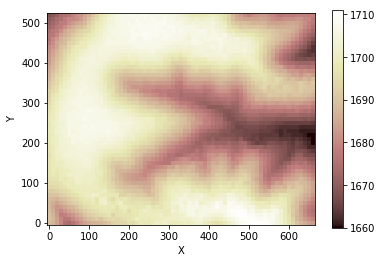

In [3]:
(watershed,z)=read_esri_ascii('DEM_10m.asc', name='topographic__elevation')
imshow_grid(watershed, 'topographic__elevation')

Constructions of Landlab Radiation and Potential Evapotranspiration components and codes can be found in the respective links below.
http://landlab.readthedocs.io/en/latest/landlab.components.radiation.html and
http://landlab.readthedocs.io/en/latest/landlab.components.pet.html
The radation components return relative radiation (ratio of radiation of a slopes surface to flat surface), used to scale PET calculated for flat surface by the PET component. 

Let's instantiate the radiation and PET components using only variables relevant to this exercise. 

In [4]:
rad = Radiation(watershed, method='Grid', latitude=34.)
PET=PotentialEvapotranspiration(watershed, method='PriestleyTaylor', albedo=0.2, latitude=34., elevation_of_measurement=2, )

Set the current_time (0-1) in a year, (calculate as DOY/365).
To see how the magnitude and spatial distribution of radiation and PET changes as a function of DOY we will use two different days, summer and winter solstice. In both cases we will use PET based on the Priestley and Taylor model that requires temperature as input. Temperatures are from cenral NM climatology. In the calculation of PET modeled solar radiation will be used. The Potential Evapotranspiration component of Landlab currently offers several other methods for PET calculation which can be found: http://landlab.readthedocs.io/en/latest/landlab.components.pet.html

For summer solstice use current_time=0.466 (June 20) and Tmin=14,  Tmax=32, Tavg=23 (degree C) 

For summer solstice use current_time=0.997 (December 21) and Tmin=-5,  Tmax=11, Tavg=3 (degree C).
As you do this exercise notice when the spatial variability of radiation and PET becomes more pronounced.

In [5]:
current_time=0.466   # 0: beginning of the calender year 0.5: middle of the year
rad.update(current_time)
PET.update(current_time, Tmin=14, Tmax=32, Tavg=23)  # Daily min, max, and average temperature

Let's identify the outputs we can plot and examine

In [6]:
sorted(PotentialEvapotranspiration.output_var_names)

['radiation__incoming_shortwave_flux',
 'radiation__net_flux',
 'radiation__net_longwave_flux',
 'radiation__net_shortwave_flux',
 'surface__potential_evapotranspiration_rate']

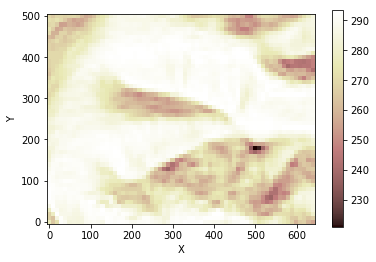

In [8]:
imshow_grid(watershed,'radiation__net_shortwave_flux', values_at='cell')

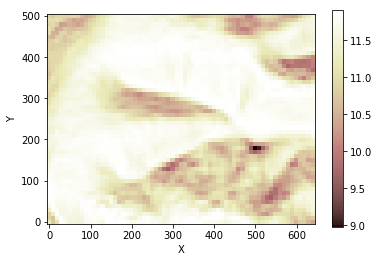

In [9]:
imshow_grid(watershed,'surface__potential_evapotranspiration_rate', values_at='cell')

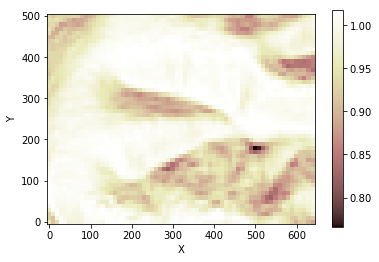

In [10]:
imshow_grid(watershed,'radiation__ratio_to_flat_surface', values_at='cell')

Now we will run the soil moisuture and vegetation response models on this DEM, driven by a rainfall depth and PET caclulated above. 
Firs let's import the components.

In [11]:
from landlab.components.soil_moisture import SoilMoisture
from landlab.components import Vegetation

In [12]:
# Input parameters for the model
Vegetation_Type=0                 # grass=0, shrub=1, tree=2, bare=3
Vegetation_cover=0.5;             # initial vegetation ground cover fraction (0-1) keep this fixed, updated when the vegetation model is used
Initial_soil_saturation=0.3;      # initial soil saturation in the root zone (0-1)
Rainfall=50                      # rainfall depth (mm) 
Tb=15                            # time between storm (days) this is used as model run duration without any rainfall 
initial_live_biomass=30.        # Initial live biomass in g DM m^-2
initial_dead_biomass=30.        # Initial dead biomass in g DM m^-2

In [13]:
sorted(SoilMoisture.output_var_names) 

['soil_moisture__root_zone_leakage',
 'soil_moisture__saturation_fraction',
 'surface__evapotranspiration',
 'surface__runoff',
 'vegetation__water_stress']

Soil moisture model varaibles and their units

In [14]:
sorted(SoilMoisture.units) 

[('rainfall__daily_depth', 'mm'),
 ('soil_moisture__initial_saturation_fraction', 'None'),
 ('soil_moisture__root_zone_leakage', 'mm'),
 ('soil_moisture__saturation_fraction', 'None'),
 ('surface__evapotranspiration', 'mm'),
 ('surface__potential_evapotranspiration_rate', 'mm'),
 ('surface__runoff', 'mm'),
 ('vegetation__cover_fraction', 'None'),
 ('vegetation__live_leaf_area_index', 'None'),
 ('vegetation__plant_functional_type', 'None'),
 ('vegetation__water_stress', 'None')]

Construction of the soil moisture class includes the default varaibles for central New Mexico conditions in the link below: 
http://landlab.readthedocs.io/en/latest/_modules/landlab/components/soil_moisture/soil_moisture_dynamics.html#SoilMoisture.update
Default parameter values can be changed by including during instantiation of the component below: 

In [15]:
watershed['cell']['vegetation__plant_functional_type']=Vegetation_Type * np.ones(watershed.number_of_cells, dtype=int)
SM = SoilMoisture(watershed, runon=1, f_bare=0.7)

Assign initial soil-water and vegetation conditions, and make rainfall a spatial  input 

In [16]:
watershed['cell']['soil_moisture__initial_saturation_fraction']=Initial_soil_saturation*np.ones(watershed.number_of_cells)
watershed['cell']['vegetation__cover_fraction']=Vegetation_cover*np.ones(watershed.number_of_cells)
watershed['cell']['rainfall__daily'] = Rainfall*np.ones(watershed.number_of_cells)

Let's map the initial soil moisture before storm

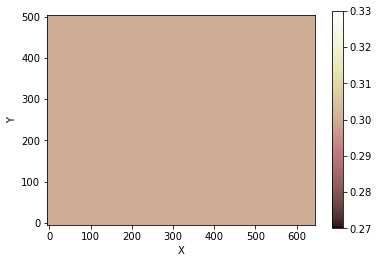

In [17]:
imshow_grid(watershed,'soil_moisture__initial_saturation_fraction', values_at='cell')

run the soil moisture model now

In [18]:
current_time = SM.update(current_time, Tb=Tb*24.)

array([ 0.14698686,  0.14881478,  0.14756007, ...,  0.14756938,
        0.14658632,  0.14570808])

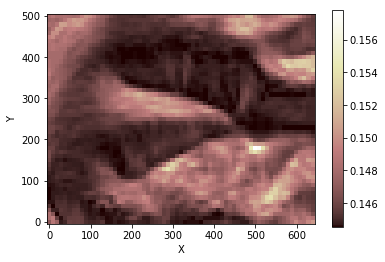

In [19]:
imshow_grid(watershed,'soil_moisture__saturation_fraction', values_at='cell')
watershed['cell']['soil_moisture__saturation_fraction']

Let's check if there is any plant water stress during the period of soil moisture drawdown and think about why/ why not

array([ 0.35807581,  0.3541565 ,  0.35684329, ...,  0.35682329,
        0.35893895,  0.36083696])

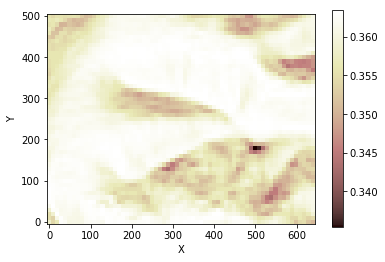

In [20]:
imshow_grid(watershed,'vegetation__water_stress', values_at='cell')
watershed['cell']['vegetation__water_stress']

In [21]:
sorted(Vegetation.input_var_names)  

['surface__evapotranspiration',
 'surface__potential_evapotranspiration_30day_mean',
 'surface__potential_evapotranspiration_rate',
 'vegetation__plant_functional_type',
 'vegetation__water_stress']

The vegetation dynamics model has a running average of 30-day PET used to detect the beginning and end of the growing season. For example when the 30-day average PET is lower than a threshold growth stops. 
Here we will use the 30-day avarege PET the same as the calculated PET earlier for simplicity. 

In [22]:
watershed['cell']['surface__potential_evapotranspiration_30day_mean'] = watershed['cell']['surface__potential_evapotranspiration_rate']

Construction of the Vegetation class includes the default varaibles for central New Mexico conditions which can be found in the link below: 
http://landlab.readthedocs.io/en/latest/landlab.components.single_vegetation.html

Default parameter values can be changed by including them in the instantiation of the component below. Here you can set the initial live and dead vegetaiton biomass and simulate change (growth or decay) during Tb. Unit of biomass is gr Dry Matter per m2 

In [23]:
Veg=Vegetation(watershed, Blive_init=initial_live_biomass, Bdead_init=initial_dead_biomass)
Veg.update(Tb=Tb*24.)
sorted(Vegetation.output_var_names) 

['vegetation__cover_fraction',
 'vegetation__dead_biomass',
 'vegetation__dead_leaf_area_index',
 'vegetation__live_biomass',
 'vegetation__live_leaf_area_index']

Now let's map (and print as needed) outputs from the soil moisture and vegetation models: live biomass, LAI of live plants, total loss of ET and leakage from the bottom of the root-zone for the entire duration (Tb) of the model run.

array([ 102.38558321,  101.66692034,  102.16062638, ...,  102.15696859,
        102.54255566,  102.88610383])

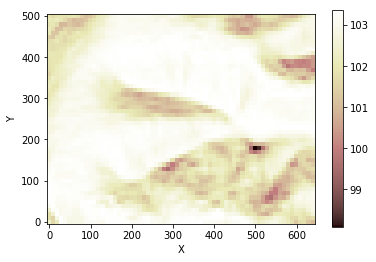

In [24]:
imshow_grid(watershed,'vegetation__live_biomass', values_at='cell')
watershed['cell']['vegetation__live_biomass']

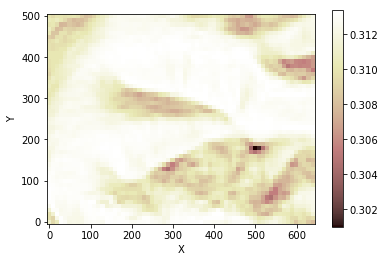

In [25]:
imshow_grid(watershed,'vegetation__live_leaf_area_index', values_at='cell')

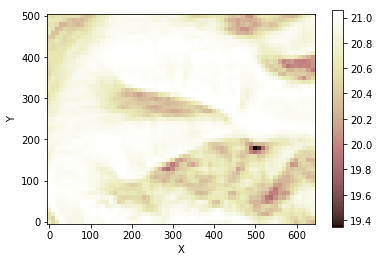

In [26]:
imshow_grid(watershed,'surface__evapotranspiration', values_at='cell')

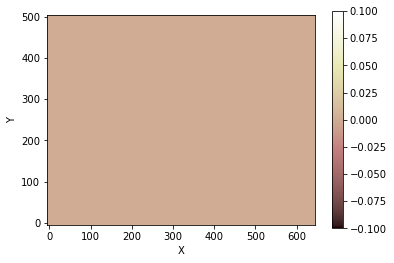

In [27]:
imshow_grid(watershed,'soil_moisture__root_zone_leakage', values_at='cell')

Let's save one of the output fields using numpy.save()

In [28]:
np.save('soil_moisture_root_zone_leakage.npy', watershed['cell']['soil_moisture__root_zone_leakage'])

To load the values we saved earlier, use numpy.load()

In [29]:
new_var = np.load('soil_moisture_root_zone_leakage.npy')
new_var

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

Now you can explore the ecohydrologic response of this model by changing DOY, temperature, lenght of the run (e.g.,Tb), initial soil moisture conditions, and rainfall depth. Note that we make the assumption that PET varaibles do not change over the duration of Tb. For a fully coupled run examples, please see other study examples that use the Cellular Automaton model.